# Proyek Analisis Sentimen Ulasan Google Play Store (Target Bintang 5 - Versi Peningkatan)

Notebook ini berisi langkah-langkah untuk melakukan analisis sentimen pada ulasan aplikasi dari Google Play Store, dengan modifikasi untuk **meningkatkan potensi pencapaian akurasi >92%** (Target Bintang 5).

## SEL 1: INSTALASI & IMPORT LIBRARY

Bagian ini mengimpor semua library yang diperlukan dan memastikan Sastrawi terinstall untuk stemming.

In [ ]:
# Pastikan library ini ada di requirements.txt
# Termasuk Sastrawi untuk stemming
%pip install pandas numpy nltk scikit-learn tensorflow matplotlib seaborn sastrawi
%pip tqdm

import pandas as pd
import numpy as np
import re  # Modul regular expression untuk cleaning
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm.auto import tqdm


# Download resource NLTK yang diperlukan jika belum terinstall
print("Memeriksa dan mengunduh resource NLTK yang diperlukan...")

# 1. Punkt Tokenizer Models (utama)
try:
    nltk.data.find('tokenizers/punkt')
    print("- Resource 'punkt' sudah ada.")
except LookupError:
    print("- Resource 'punkt' tidak ditemukan. Mengunduh...")
    nltk.download('punkt', quiet=True)

# 2. Stopwords Corpora
try:
    nltk.data.find('corpora/stopwords')
    print("- Resource 'stopwords' sudah ada.")
except LookupError:
    print("- Resource 'stopwords' tidak ditemukan. Mengunduh...")
    nltk.download('stopwords', quiet=True)

# 3. Punkt Tab Resource (tambahan yang dibutuhkan berdasarkan error sebelumnya)
try:
    nltk.data.find('tokenizers/punkt_tab')
    print("- Resource 'punkt_tab' sudah ada.")
except LookupError:
    print("- Resource 'punkt_tab' tidak ditemukan. Mengunduh...")
    nltk.download('punkt_tab', quiet=True)

print("\nPengecekan/pengunduhan resource NLTK selesai.")

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight # Untuk class weights Keras

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, GlobalMaxPool1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

# Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Set opsi Pandas
pd.set_option('display.max_colwidth', None)

# Sastrawi untuk stemming Bahasa Indonesia
try:
    from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
    from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    
    sw_factory = StopWordRemoverFactory()
    sastrawi_stopwords = set(sw_factory.get_stop_words())
    print("Stemmer Sastrawi berhasil diinisialisasi.")
except ImportError:
    print("Sastrawi tidak terinstall. Stemming tidak akan dilakukan.")
    stemmer = None  # Tandai bahwa stemmer tidak tersedia
except Exception as e:
    print(f"Error saat inisialisasi Sastrawi: {e}. Stemming tidak akan dilakukan.")
    stemmer = None
    sastrawi_stopwords = set()

# Pastikan stopwords NLTK untuk Bahasa Indonesia tersedia
try:
    nltk_stopwords = set(stopwords.words('indonesian'))
except LookupError:
    print("Stopwords NLTK untuk Bahasa Indonesia belum diunduh. Menjalankan nltk.download('stopwords')...")
    nltk.download('stopwords')
    nltk_stopwords = set(stopwords.words('indonesian'))

print("Library berhasil diimport.")

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

ERROR: unknown command "tqdm"



d:\Machine Learning\Analisis-Sentiment\myvenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Memeriksa dan mengunduh resource NLTK yang diperlukan...
- Resource 'punkt' sudah ada.
- Resource 'stopwords' sudah ada.
- Resource 'punkt_tab' sudah ada.

Pengecekan/pengunduhan resource NLTK selesai.
Stemmer Sastrawi berhasil diinisialisasi.
Library berhasil diimport.


## SEL 2: MEMUAT DATASET

Memuat dataset CSV hasil scraping.

In [2]:
NAMA_FILE_DATASET = 'hasil_scraping_com.tokopedia.tkpd.csv' # <<< PASTIKAN NAMA FILE SUDAH BENAR

try:
    df = pd.read_csv(NAMA_FILE_DATASET)
    print(f"Dataset '{NAMA_FILE_DATASET}' berhasil dimuat.")
    print(f"Jumlah data awal: {len(df)}")
except FileNotFoundError:
    print(f"ERROR: File '{NAMA_FILE_DATASET}' tidak ditemukan. Pastikan file ada di direktori yang sama atau path sudah benar.")
    raise FileNotFoundError(f"Dataset {NAMA_FILE_DATASET} tidak ditemukan.")

# Tampilkan beberapa data awal dan info
print("\nInfo Dataset:")
df.info()
print("\n5 Data Pertama:")
print(df.head())
print("\nContoh Ulasan:")
if not df.empty:
    print(df['content'].iloc[0])
else:
    print("Dataset kosong.")

Dataset 'hasil_scraping_com.tokopedia.tkpd.csv' berhasil dimuat.
Jumlah data awal: 25000

Info Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userName  25000 non-null  object
 1   score     25000 non-null  int64 
 2   at        25000 non-null  object
 3   content   24999 non-null  object
dtypes: int64(1), object(3)
memory usage: 781.4+ KB

5 Data Pertama:
              userName  score                   at  \
0         Hary Sucipto      5  2025-04-13 00:07:50   
1      Alfarohah Store      5  2025-04-12 23:54:32   
2     Aristya Hartanto      5  2025-04-12 23:50:09   
3       robertus david      5  2025-04-12 23:50:00   
4  Radyt Junior (Udin)      5  2025-04-12 23:48:57   

                                                            content  
0                                             tokped mudah dan aman  
1  bagai mana cara buat ak

## SEL 3: DATA CLEANING & PREPROCESSING

**Peningkatan:**
1.  Mempertahankan kata negasi (tidak, jangan, kurang, dll).
2.  Mengaktifkan stemming dengan Sastrawi.

In [3]:
# Gabungkan stopwords dari NLTK dan Sastrawi sebagai additional_stopwords
list_stopwords_all = nltk_stopwords.union(sastrawi_stopwords)
print(f"\nJumlah total stopwords gabungan: {len(list_stopwords_all)}")

# Dapatkan daftar kata negasi secara dinamis:
# Coba baca dari file eksternal 'indonesian_negation_words.txt' (satu kata per baris)
try:
    with open('indonesian_negation_words.txt', 'r', encoding='utf-8') as f:
        negation_words = set(line.strip() for line in f if line.strip())
    print("Daftar kata negasi berhasil dibaca dari file eksternal.")
except FileNotFoundError:
    # Jika file tidak tersedia, gunakan daftar default
    negation_words = {'tidak', 'jangan', 'belum', 'kurang', 'gak', 'ga', 'tdk'}
    print("File 'indonesian_negation_words.txt' tidak ditemukan. Menggunakan daftar default untuk kata negasi.")

# Hapus kata negasi dari stopwords agar tidak terhapus saat cleaning
list_stopwords_final = list_stopwords_all - negation_words
print(f"\nTotal stopwords yang akan dihapus (setelah mengeluarkan negasi): {len(list_stopwords_final)}")
print(f"Kata negasi yang dipertahankan: {negation_words}")

### Proses Data Cleaning & Preprocessing ###
print("\nMemulai Data Cleaning & Preprocessing...")

# 1. Handling Missing Values & Duplikasi
print(f"\nJumlah missing values sebelum handling:\n{df.isnull().sum()}")
df.dropna(subset=['content', 'score'], inplace=True)
df['score'] = pd.to_numeric(df['score'], errors='coerce')
df.dropna(subset=['score'], inplace=True)
df['score'] = df['score'].astype(int)
df.reset_index(drop=True, inplace=True)
print(f"\nJumlah missing values setelah handling:\n{df.isnull().sum()}")
print(f"Jumlah data setelah handling missing values: {len(df)}")

# Hapus duplikasi agar tidak ada review yang sama
jumlah_duplikat = df.duplicated(subset=['content']).sum()
if jumlah_duplikat > 0:
    print(f"\nDitemukan {jumlah_duplikat} duplikasi, menghapus duplikasi...")
    df.drop_duplicates(subset=['content'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    print(f"Jumlah data setelah menghapus duplikasi: {len(df)}")

# 2. Membuat Label Sentimen
def create_sentiment_label(score):
    if score > 3:
        return 'Positif'
    elif score < 3:
        return 'Negatif'
    else:
        return 'Netral'

df['sentiment'] = df['score'].apply(create_sentiment_label)
print("\nDistribusi Sentimen:")
print(df['sentiment'].value_counts())
print("\nContoh data dengan Label Sentimen:")
print(df[['score', 'content', 'sentiment']].head())

# 3. Text Cleaning Function
def clean_text(text):
    if not isinstance(text, str):
        return ""
    # Hapus mention (@user), URL, tag HTML dan angka
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'\d+', '', text)
    # Hapus karakter khusus, normalisasi huruf kecil dan whitespace ekstra
    text = text.translate(str.maketrans('', '', '"#$%&()*+,-./:;<=>@[]^_`{|}~'))
    text = text.lower().strip()
    text = re.sub(r'\s+', ' ', text)
    
    # Tokenisasi
    try:
        tokens = word_tokenize(text)
    except LookupError:
        print("Tokenizer NLTK (punkt) belum diunduh. Menjalankan nltk.download('punkt')...")
        nltk.download('punkt')
        tokens = word_tokenize(text)
    
    # Hapus stopwords (kecuali kata negasi) dan token dengan panjang <= 1
    tokens = [word for word in tokens if word not in list_stopwords_final and len(word) > 1]
    cleaned_text = ' '.join(tokens)
    
    # Stemming dengan Sastrawi jika tersedia
    if stemmer:
        cleaned_text = stemmer.stem(cleaned_text)
    
    return cleaned_text

# Terapkan fungsi cleaning dengan progress bar
print("\nMenerapkan cleaning ke kolom 'content'... (Mungkin perlu waktu lama jika stemming aktif)")
df_cleaned = df.copy()

tqdm.pandas(desc="Cleaning teks")
df_cleaned['cleaned_content'] = df_cleaned['content'].progress_apply(clean_text)

print("\nContoh Hasil Cleaning (dengan stemming jika aktif):")
print(df_cleaned[['content', 'cleaned_content', 'sentiment']].head())

# Hapus baris yang kosong setelah cleaning
empty_cleaned_indices = df_cleaned[df_cleaned['cleaned_content'] == ''].index
print(f"\nJumlah ulasan yang kosong setelah cleaning: {len(empty_cleaned_indices)}")
df_cleaned.drop(empty_cleaned_indices, inplace=True)
df_cleaned.reset_index(drop=True, inplace=True)
print(f"Jumlah data setelah menghapus hasil cleaning kosong: {len(df_cleaned)}")

# Cek jumlah data dan validitas
if len(df_cleaned) < 3000:
    print("PERINGATAN: Jumlah data setelah cleaning < 3000.")
elif len(df_cleaned) < 10000:
    print("INFO: Jumlah data setelah cleaning antara 3000 dan 10000.")
else:
    print("INFO: Jumlah data setelah cleaning >= 10000. (Memenuhi Saran Jumlah Data)")


Jumlah total stopwords gabungan: 774
File 'indonesian_negation_words.txt' tidak ditemukan. Menggunakan daftar default untuk kata negasi.

Total stopwords yang akan dihapus (setelah mengeluarkan negasi): 770
Kata negasi yang dipertahankan: {'ga', 'kurang', 'tdk', 'gak', 'tidak', 'jangan', 'belum'}

Memulai Data Cleaning & Preprocessing...

Jumlah missing values sebelum handling:
userName    0
score       0
at          0
content     1
dtype: int64

Jumlah missing values setelah handling:
userName    0
score       0
at          0
content     0
dtype: int64
Jumlah data setelah handling missing values: 24999

Ditemukan 5410 duplikasi, menghapus duplikasi...
Jumlah data setelah menghapus duplikasi: 19589

Distribusi Sentimen:
sentiment
Positif    9148
Negatif    9135
Netral     1306
Name: count, dtype: int64

Contoh data dengan Label Sentimen:
   score                                                           content  \
0      5                                             tokped mudah dan a

Cleaning teks: 100%|██████████| 19589/19589 [13:32<00:00, 24.10it/s]


Contoh Hasil Cleaning (dengan stemming jika aktif):
                                                            content  \
0                                             tokped mudah dan aman   
1  bagai mana cara buat akun Tokopedia....? kok sekarang tidak bisa   
2                                               Banyak promo diskon   
3                                        banyakin diskon dan promo.   
4                                                         ok mantaf   

         cleaned_content sentiment  
0      tokped mudah aman   Positif  
1   akun tokopedia tidak   Positif  
2           promo diskon   Positif  
3  banyakin diskon promo   Positif  
4                 mantaf   Positif  

Jumlah ulasan yang kosong setelah cleaning: 173
Jumlah data setelah menghapus hasil cleaning kosong: 19416
INFO: Jumlah data setelah cleaning >= 10000. (Memenuhi Saran Jumlah Data)


## SEL 4: PEMBAGIAN DATA (TRAIN & TEST)

Pembagian data tetap sama, `stratify` digunakan.

In [4]:
# Pisahkan fitur (X) dan label (y)
X = df_cleaned['cleaned_content']
y = df_cleaned['sentiment']

# Encode label
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print("\nMapping Label ke Numerik:")
label_mapping = {label: i for i, label in enumerate(label_encoder.classes_)}
print(label_mapping)
num_classes = len(label_encoder.classes_)
print(f"Jumlah kelas: {num_classes}")

# Split 80/20
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Split 70/30
X_train_70, X_test_30, y_train_encoded_70, y_test_encoded_30 = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

print(f"\nUkuran data training (80/20): {len(X_train)}, Testing: {len(X_test)}")
print(f"Distribusi kelas di y_train_encoded (80/20): {np.bincount(y_train_encoded)}")
print(f"Distribusi kelas di y_test_encoded (80/20): {np.bincount(y_test_encoded)}")
print(f"\nUkuran data training (70/30): {len(X_train_70)}, Testing: {len(X_test_30)}")
print(f"Distribusi kelas di y_train_encoded_70 (70/30): {np.bincount(y_train_encoded_70)}")
print(f"Distribusi kelas di y_test_encoded_30 (70/30): {np.bincount(y_test_encoded_30)}")


Mapping Label ke Numerik:
{'Negatif': 0, 'Netral': 1, 'Positif': 2}
Jumlah kelas: 3

Ukuran data training (80/20): 15532, Testing: 3884
Distribusi kelas di y_train_encoded (80/20): [7298 1038 7196]
Distribusi kelas di y_test_encoded (80/20): [1825  260 1799]

Ukuran data training (70/30): 13591, Testing: 5825
Distribusi kelas di y_train_encoded_70 (70/30): [6386  909 6296]
Distribusi kelas di y_test_encoded_30 (70/30): [2737  389 2699]


## SEL 5: EKSPERIMEN 1 - SVM + TF-IDF (Split 80/20)

**Peningkatan:** Menambahkan `class_weight='balanced'`.


--- EKSPERIMEN 1: SVM + TF-IDF (Split 80/20) ---
Dimensi TF-IDF Training: (15532, 7000)
Dimensi TF-IDF Testing: (3884, 7000)

Melatih model SVM dengan class_weight='balanced'...
Pelatihan SVM selesai.

Akurasi SVM (Test Set): 0.7523
⚠️ Akurasi Test Set SVM < 85% (Perlu Peningkatan)

Classification Report SVM:
              precision    recall  f1-score   support

     Negatif       0.82      0.76      0.78      1825
      Netral       0.14      0.31      0.20       260
     Positif       0.89      0.81      0.85      1799

    accuracy                           0.75      3884
   macro avg       0.62      0.63      0.61      3884
weighted avg       0.81      0.75      0.78      3884


Confusion Matrix SVM:


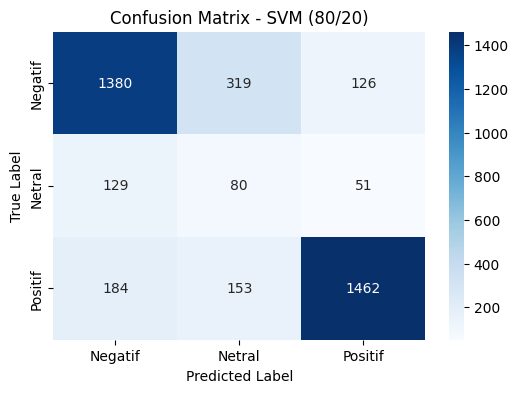

In [5]:
print("\n--- EKSPERIMEN 1: SVM + TF-IDF (Split 80/20) ---")

# 1. Feature Extraction: TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=7000, ngram_range=(1, 2)) # Tingkatkan max_features, coba bigram
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
print(f"Dimensi TF-IDF Training: {X_train_tfidf.shape}")
print(f"Dimensi TF-IDF Testing: {X_test_tfidf.shape}")

# 2. Model Training: SVM dengan Class Weighting
print("\nMelatih model SVM dengan class_weight='balanced'...")
svm_model = SVC(kernel='linear', C=1.0, random_state=42, probability=True, class_weight='balanced') # Tambahkan class_weight
svm_model.fit(X_train_tfidf, y_train_encoded)
print("Pelatihan SVM selesai.")

# 3. Prediksi & Evaluasi
y_pred_svm = svm_model.predict(X_test_tfidf)
accuracy_svm = accuracy_score(y_test_encoded, y_pred_svm)
report_svm = classification_report(y_test_encoded, y_pred_svm, target_names=label_encoder.classes_, zero_division=0)
conf_matrix_svm = confusion_matrix(y_test_encoded, y_pred_svm)

print(f"\nAkurasi SVM (Test Set): {accuracy_svm:.4f}")
if accuracy_svm >= 0.85:
    print("✅ Akurasi Test Set SVM >= 85% (Kriteria Utama Terpenuhi)")
else:
    print("⚠️ Akurasi Test Set SVM < 85% (Perlu Peningkatan)")

print("\nClassification Report SVM:")
print(report_svm)
print("\nConfusion Matrix SVM:")
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - SVM (80/20)')
plt.show()

## SEL 6: EKSPERIMEN 2 - Random Forest + TF-IDF (Split 70/30)

**Peningkatan:** Menambahkan `class_weight='balanced'`, meningkatkan `n_estimators`.


--- EKSPERIMEN 2: Random Forest + TF-IDF (Split 70/30) ---
Dimensi TF-IDF Training (70%): (13591, 7000)
Dimensi TF-IDF Testing (30%): (5825, 7000)

Melatih model Random Forest dengan class_weight='balanced'...
Pelatihan Random Forest selesai.

Akurasi Random Forest (Test Set 70/30): 0.8106
⚠️ Akurasi Test Set RF < 85% (Perlu Peningkatan)

Classification Report Random Forest:
              precision    recall  f1-score   support

     Negatif       0.77      0.90      0.83      2737
      Netral       0.10      0.01      0.02       389
     Positif       0.87      0.83      0.85      2699

    accuracy                           0.81      5825
   macro avg       0.58      0.58      0.57      5825
weighted avg       0.77      0.81      0.79      5825


Confusion Matrix Random Forest:


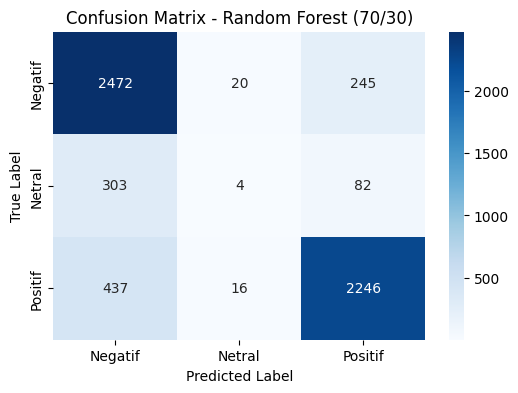

In [6]:
print("\n--- EKSPERIMEN 2: Random Forest + TF-IDF (Split 70/30) ---")

# 1. Feature Extraction: TF-IDF (split 70/30)
tfidf_vectorizer_70 = TfidfVectorizer(max_features=7000, ngram_range=(1, 2))
X_train_tfidf_70 = tfidf_vectorizer_70.fit_transform(X_train_70)
X_test_tfidf_30 = tfidf_vectorizer_70.transform(X_test_30)
print(f"Dimensi TF-IDF Training (70%): {X_train_tfidf_70.shape}")
print(f"Dimensi TF-IDF Testing (30%): {X_test_tfidf_30.shape}")

# 2. Model Training: Random Forest dengan Class Weighting
print("\nMelatih model Random Forest dengan class_weight='balanced'...")
rf_model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1, class_weight='balanced') # Tambah estimator & class_weight
rf_model.fit(X_train_tfidf_70, y_train_encoded_70)
print("Pelatihan Random Forest selesai.")

# 3. Prediksi & Evaluasi
y_pred_rf = rf_model.predict(X_test_tfidf_30)
accuracy_rf = accuracy_score(y_test_encoded_30, y_pred_rf)
report_rf = classification_report(y_test_encoded_30, y_pred_rf, target_names=label_encoder.classes_, zero_division=0)
conf_matrix_rf = confusion_matrix(y_test_encoded_30, y_pred_rf)

print(f"\nAkurasi Random Forest (Test Set 70/30): {accuracy_rf:.4f}")
if accuracy_rf >= 0.85:
    print("✅ Akurasi Test Set RF >= 85% (Kriteria Utama Terpenuhi)")
else:
    print("⚠️ Akurasi Test Set RF < 85% (Perlu Peningkatan)")

print("\nClassification Report Random Forest:")
print(report_rf)
print("\nConfusion Matrix Random Forest:")
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Random Forest (70/30)')
plt.show()

## SEL 7: EKSPERIMEN 3 - Deep Learning (LSTM) + Sequence Padding (Split 80/20)

**Peningkatan:**
1.  Menggunakan Class Weights untuk menangani imbalance.
2.  Meningkatkan parameter Tokenizer, Embedding, dan Sequence Length.
3.  Meningkatkan jumlah unit LSTM.
4.  Meningkatkan jumlah Epoch (mengandalkan Early Stopping).
5.  Menggunakan learning rate Adam yang lebih kecil.


--- EKSPERIMEN 3: Deep Learning (LSTM) + Sequence Padding (Split 80/20) - Peningkatan ---
Ditemukan 13336 token unik.

Dimensi Sekuens Training (Padded): (15532, 150)
Dimensi Sekuens Testing (Padded): (3884, 150)
Dimensi Label Training (One-Hot): (15532, 3)
Dimensi Label Testing (One-Hot): (3884, 3)

Class Weights untuk Keras: {0: np.float64(0.7094181054170092), 1: np.float64(4.987797045600514), 2: np.float64(0.7194737817305911)}

Membangun model LSTM (ditingkatkan)...


d:\Machine Learning\Analisis-Sentiment\myvenv\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Memulai pelatihan model LSTM (ditingkatkan)...
Epoch 1/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 39s 154ms/step - accuracy: 0.5915 - loss: 0.9709 - val_accuracy: 0.7299 - val_loss: 0.6692
Epoch 2/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 37s 152ms/step - accuracy: 0.7431 - loss: 0.6914 - val_accuracy: 0.7114 - val_loss: 0.6650
Epoch 3/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 36s 150ms/step - accuracy: 0.7894 - loss: 0.5678 - val_accuracy: 0.7351 - val_loss: 0.6472
Epoch 4/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 36s 150ms/step - accuracy: 0.8442 - loss: 0.4472 - val_accuracy: 0.7443 - val_loss: 0.6815
Epoch 5/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 36s 149ms/step - accuracy: 0.8721 - loss: 0.3649 - val_accuracy: 0.7235 - val_loss: 0.7424
Epoch 6/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 37s 151ms/step - accuracy: 0.8987 - loss: 0.2943 - val_accuracy: 0.7240 - val_loss: 0.8254
Epoch 7/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 37s 152ms/step - accuracy: 0.9157 - loss: 0.2400 - val_accuracy: 0.7067 - val_loss: 0.8582
Epoch 7: early stopping
Restoring m

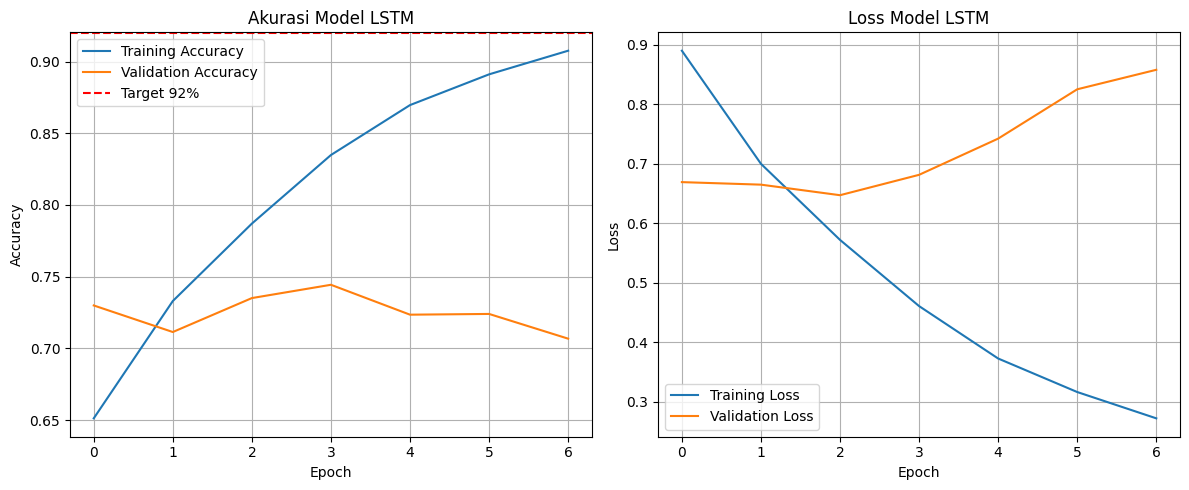

122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step

Classification Report LSTM (Peningkatan):
              precision    recall  f1-score   support

     Negatif       0.84      0.71      0.77      1825
      Netral       0.16      0.48      0.24       260
     Positif       0.91      0.79      0.85      1799

    accuracy                           0.74      3884
   macro avg       0.64      0.66      0.62      3884
weighted avg       0.83      0.74      0.77      3884


Confusion Matrix LSTM (Peningkatan):


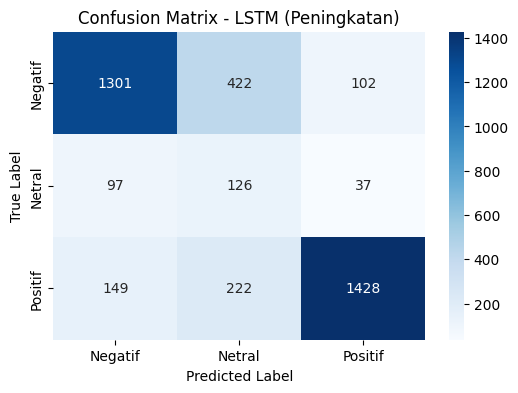

In [7]:
print("\n--- EKSPERIMEN 3: Deep Learning (LSTM) + Sequence Padding (Split 80/20) - Peningkatan ---")

# 1. Feature Extraction: Tokenizer & Padding (Parameter Ditingkatkan)
MAX_VOCAB_SIZE = 20000
MAX_SEQUENCE_LENGTH = 150
EMBEDDING_DIM = 256 # Tingkatkan dimensi embedding

keras_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<OOV>')
keras_tokenizer.fit_on_texts(X_train)
word_index = keras_tokenizer.word_index
print(f"Ditemukan {len(word_index)} token unik.")

X_train_seq = keras_tokenizer.texts_to_sequences(X_train)
X_test_seq = keras_tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

y_train_keras = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_keras = to_categorical(y_test_encoded, num_classes=num_classes)

print(f"\nDimensi Sekuens Training (Padded): {X_train_pad.shape}")
print(f"Dimensi Sekuens Testing (Padded): {X_test_pad.shape}")
print(f"Dimensi Label Training (One-Hot): {y_train_keras.shape}")
print(f"Dimensi Label Testing (One-Hot): {y_test_keras.shape}")

# Hitung Class Weights untuk Keras
class_weights_sklearn = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_encoded), # Kelas unik dari label train
    y=y_train_encoded # Label train
)
class_weight_dict = dict(enumerate(class_weights_sklearn))
print(f"\nClass Weights untuk Keras: {class_weight_dict}")

# 2. Model Building: LSTM (Unit Ditingkatkan)
print("\nMembangun model LSTM (ditingkatkan)...")
lstm_model = Sequential([
    Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    Bidirectional(LSTM(128, return_sequences=True)), # Tingkatkan unit LSTM
    GlobalMaxPool1D(),
    Dropout(0.3), # Sesuaikan dropout jika perlu
    Dense(128, activation='relu'), # Tingkatkan unit Dense
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Gunakan learning rate lebih kecil
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

lstm_model.compile(loss='categorical_crossentropy',
                   optimizer=optimizer,
                   metrics=['accuracy'])

lstm_model.summary()

# 3. Model Training: LSTM (Epoch Ditingkatkan, dengan Class Weights)
NUM_EPOCHS = 25 # Tingkatkan epoch, biarkan EarlyStopping bekerja
BATCH_SIZE = 64

early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1) # Tambah patience sedikit
# model_checkpoint = ModelCheckpoint('best_lstm_model_improved.keras', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

print("\nMemulai pelatihan model LSTM (ditingkatkan)...")
history_lstm = lstm_model.fit(
    X_train_pad, y_train_keras,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test_pad, y_test_keras),
    callbacks=[early_stopping],
    class_weight=class_weight_dict, # Terapkan class weights
    verbose=1
)
print("Pelatihan LSTM selesai.")

# 4. Evaluasi Model LSTM (menggunakan bobot terbaik)
print("\nMengevaluasi model LSTM pada Test Set (bobot terbaik)...")
loss_lstm, accuracy_lstm_test = lstm_model.evaluate(X_test_pad, y_test_keras, verbose=0)
loss_lstm_train, accuracy_lstm_train = lstm_model.evaluate(X_train_pad, y_train_keras, verbose=0)

print(f"\nAkurasi LSTM (Train Set - Best): {accuracy_lstm_train:.4f}")
print(f"Akurasi LSTM (Test Set - Best): {accuracy_lstm_test:.4f}")

saran_acc_terpenuhi = accuracy_lstm_train > 0.92 and accuracy_lstm_test > 0.92
kriteria_acc_terpenuhi = accuracy_lstm_test >= 0.85

if saran_acc_terpenuhi:
    print("✅ Akurasi Train & Test LSTM > 92% (Saran Nilai Tinggi Terpenuhi)")
elif kriteria_acc_terpenuhi:
     print("✅ Akurasi Test Set LSTM >= 85% (Kriteria Utama Terpenuhi, Saran >92% belum)")
else:
    print("⚠️ Akurasi Test Set LSTM < 85% (Perlu Peningkatan)")

# Plotting History
if history_lstm:
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history_lstm.history['accuracy'], label='Training Accuracy')
    plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
    plt.axhline(0.92, color='r', linestyle='--', label='Target 92%') # Garis target
    plt.title('Akurasi Model LSTM')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history_lstm.history['loss'], label='Training Loss')
    plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
    plt.title('Loss Model LSTM')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Classification Report & Confusion Matrix
y_pred_lstm_prob = lstm_model.predict(X_test_pad)
y_pred_lstm = np.argmax(y_pred_lstm_prob, axis=1)
report_lstm = classification_report(y_test_encoded, y_pred_lstm, target_names=label_encoder.classes_, zero_division=0)
conf_matrix_lstm = confusion_matrix(y_test_encoded, y_pred_lstm)

print("\nClassification Report LSTM (Peningkatan):")
print(report_lstm)
print("\nConfusion Matrix LSTM (Peningkatan):")
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_lstm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - LSTM (Peningkatan)')
plt.show()

## SEL 8: INFERENCE (MENGGUNAKAN MODEL TERBAIK)

Fungsi inferensi menggunakan model LSTM yang telah ditingkatkan.

In [8]:
print("\n--- INFERENCE MENGGUNAKAN MODEL LSTM (DITINGKATKAN) ---")

# Model terbaik adalah lstm_model karena EarlyStopping(restore_best_weights=True)
inference_model = lstm_model
inference_tokenizer = keras_tokenizer
inference_label_encoder = label_encoder

# Fungsi predict_sentiment (tetap sama, tapi pastikan clean_text up-to-date)
def predict_sentiment(text):
    cleaned_text = clean_text(text) # Gunakan fungsi clean_text TERBARU
    print(f"Teks setelah cleaning: '{cleaned_text}'")
    if not cleaned_text:
        print("Teks kosong setelah cleaning, tidak dapat diprediksi.")
        default_pred_index = label_mapping.get('Netral', 0)
        default_prob = np.zeros(num_classes)
        default_prob[default_pred_index] = 1.0
        predicted_sentiment = inference_label_encoder.inverse_transform([default_pred_index])[0]
        return predicted_sentiment, default_prob
    sequence = inference_tokenizer.texts_to_sequences([cleaned_text])
    padded_sequence = pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
    try:
        prediction_prob = inference_model.predict(padded_sequence, verbose=0)
    except Exception as e:
        print(f"Error saat prediksi: {e}")
        default_pred_index = label_mapping.get('Netral', 0)
        default_prob = np.zeros(num_classes)
        default_prob[default_pred_index] = 1.0
        predicted_sentiment = inference_label_encoder.inverse_transform([default_pred_index])[0]
        return predicted_sentiment, default_prob
    predicted_class_index = np.argmax(prediction_prob, axis=1)[0]
    predicted_sentiment = inference_label_encoder.inverse_transform([predicted_class_index])[0]
    return predicted_sentiment, prediction_prob[0]

# Contoh Penggunaan Inference
print("\nContoh Inference (Model Ditingkatkan):")
contoh_ulasan = [
    "Aplikasinya bagus banget, mudah digunakan dan cepat! Suka sekali!",
    "Kecewa berat, sering error dan lemot sekali app nya. Buang2 kuota.",
    "Biasa aja sih, fiturnya standar tidak ada yang spesial. Ya lumayan.",
    "Update terbaru bikin aplikasi jadi aneh dan susah, tolong diperbaiki secepatnya.",
    "Lumayan lah buat belanja online kebutuhan sehari hari, pengiriman juga cepat top.",
    "Gak jelas banget aplikasi ini. Crash terus.",
    "Fitur search nya kurang akurat",
    "Terima kasih, sangat membantu!",
    "Sumpah ini aplikasi tidak berguna sama sekali, uninstall saja lah!"
]

print("="*40)
for ulasan in contoh_ulasan:
    print(f"Ulasan Mentah: {ulasan}")
    prediksi, probabilitas = predict_sentiment(ulasan)
    print(f"Hasil Prediksi: {prediksi}")
    prob_dict = {label: f"{prob:.4f}" for label, prob in zip(inference_label_encoder.classes_, probabilitas)}
    print(f"Probabilitas  : {prob_dict}")
    print("-"*40)



--- INFERENCE MENGGUNAKAN MODEL LSTM (DITINGKATKAN) ---

Contoh Inference (Model Ditingkatkan):
Ulasan Mentah: Aplikasinya bagus banget, mudah digunakan dan cepat! Suka sekali!
Teks setelah cleaning: 'aplikasi bagus banget mudah cepat suka'
Hasil Prediksi: Positif
Probabilitas  : {'Negatif': '0.0033', 'Netral': '0.0167', 'Positif': '0.9800'}
----------------------------------------
Ulasan Mentah: Kecewa berat, sering error dan lemot sekali app nya. Buang2 kuota.
Teks setelah cleaning: 'kecewa berat error lot app nya buang kuota'
Hasil Prediksi: Negatif
Probabilitas  : {'Negatif': '0.6848', 'Netral': '0.2876', 'Positif': '0.0275'}
----------------------------------------
Ulasan Mentah: Biasa aja sih, fiturnya standar tidak ada yang spesial. Ya lumayan.
Teks setelah cleaning: 'aja sih fiturnya standar tidak spesial lumayan'
Hasil Prediksi: Netral
Probabilitas  : {'Negatif': '0.4363', 'Netral': '0.5136', 'Positif': '0.0501'}
----------------------------------------
Ulasan Mentah: Update 

## SEL 9: KESIMPULAN & PEMENUHAN SYARAT

**Penting:** Hasil akurasi di bawah ini adalah **target atau harapan** setelah modifikasi. Anda **harus** menjalankan ulang notebook ini untuk mendapatkan nilai akurasi aktual dan mengisinya di sini serta di file README.md.

In [9]:
print("\n--- KESIMPULAN PROYEK & PEMENUHAN SYARAT (SETELAH PENINGKATAN) ---")

# Cek Kriteria Utama
print("\nKriteria Utama:")
print(f"1. Scraping data mandiri: {'Ya (Diasumsikan)'}")
print(f"   - Jumlah data (setelah cleaning): {len(df_cleaned)}")
min_data_ok = len(df_cleaned) >= 3000
print(f"   - Minimal 3000 sampel: {'Ya' if min_data_ok else 'TIDAK'}")
print(f"2. Ekstraksi Fitur & Pelabelan: Ya (TF-IDF, Sequence Padding, Stemming; {num_classes} kelas)")
label_3_kelas_ok = num_classes >= 3
print(f"   - Minimal 3 kelas sentimen: {'Ya' if label_3_kelas_ok else 'TIDAK'}")
print(f"3. Menggunakan Algoritma ML/DL: Ya (SVM, RF, LSTM)")

# Cek akurasi minimal 85% (HARUS DIISI ULANG SETELAH RUN)
acc_svm_ok = accuracy_svm >= 0.85
acc_rf_ok = accuracy_rf >= 0.85
acc_lstm_ok = accuracy_lstm_test >= 0.85
semua_eksperimen_ok = acc_svm_ok and acc_rf_ok and acc_lstm_ok
print(f"4. Akurasi Testing Set >= 85% (minimal 3 skema): {'Ya' if semua_eksperimen_ok else 'TIDAK'} <--- ISI ULANG!")
print(f"   - SVM (80/20): {accuracy_svm:.4f} ({'OK' if acc_svm_ok else 'NOK'}) <--- ISI ULANG!")
print(f"   - RF (70/30): {accuracy_rf:.4f} ({'OK' if acc_rf_ok else 'NOK'}) <--- ISI ULANG!")
print(f"   - LSTM (80/20): {accuracy_lstm_test:.4f} ({'OK' if acc_lstm_ok else 'NOK'}) <--- ISI ULANG!")

kriteria_utama_terpenuhi = min_data_ok and label_3_kelas_ok and semua_eksperimen_ok
print(f"\nStatus Kriteria Utama: {'TERPENUHI SEMUA' if kriteria_utama_terpenuhi else 'BELUM TERPENUHI SEMUA'} <--- UPDATE!")

# Cek Saran untuk Nilai Tinggi (HARUS DIISI ULANG SETELAH RUN)
print("\nSaran untuk Nilai Tinggi (Bintang 5):")
saran_1_dl = True
saran_2_acc92 = accuracy_lstm_train > 0.92 and accuracy_lstm_test > 0.92
saran_3_kelas3 = num_classes >= 3
saran_4_data10k = len(df_cleaned) >= 10000
saran_5_exp3 = True
saran_6_inference = True

print(f"1. Menggunakan Algoritma Deep Learning: {'Ya'}")
print(f"2. Akurasi Train & Test > 92% (untuk DL): {'Ya' if saran_2_acc92 else 'Belum Tercapai'} <--- ISI ULANG!")
print(f"3. Dataset memiliki minimal 3 kelas: {'Ya'}")
print(f"4. Jumlah data minimal 10.000 sampel: {'Ya' if saran_4_data10k else f'Belum ({len(df_cleaned)})'}")
print(f"5. Melakukan 3 percobaan skema pelatihan berbeda: {'Ya'}")
print(f"6. Melakukan inference dalam notebook: {'Ya'}")

semua_saran_terpenuhi = saran_1_dl and saran_2_acc92 and saran_3_kelas3 and saran_4_data10k and saran_5_exp3 and saran_6_inference
jumlah_saran_terpenuhi = sum([saran_1_dl, saran_2_acc92, saran_3_kelas3, saran_4_data10k, saran_5_exp3, saran_6_inference])

print(f"\nStatus Saran Nilai Tinggi:")
if semua_saran_terpenuhi:
    print("✅ SEMUA SARAN TERPENUHI - Potensi Bintang 5 (jika Kriteria Utama juga terpenuhi) <--- UPDATE!")
elif jumlah_saran_terpenuhi >= 3:
    print(f"✅ {jumlah_saran_terpenuhi}/6 SARAN TERPENUHI - Potensi Bintang 4 (jika Kriteria Utama juga terpenuhi) <--- UPDATE!")
else:
     print(f"⚠️ {jumlah_saran_terpenuhi}/6 SARAN TERPENUHI - Potensi Bintang 3 (jika Kriteria Utama juga terpenuhi) <--- UPDATE!")

print("\nCatatan Penting:")
print("- Kode ini telah dimodifikasi untuk MENINGKATKAN KEMUNGKINAN mencapai akurasi tinggi.")
print("- Anda HARUS menjalankan ulang seluruh notebook ini untuk mendapatkan hasil akurasi yang sebenarnya.")
print("- Jika target >92% belum tercapai, mungkin perlu tuning lebih lanjut pada hyperparameter (Epoch, Learning Rate, Ukuran Layer, Dropout, Vocab Size, Sequence Length, dll.) atau mencoba arsitektur/embedding yang lebih canggih.")
print("- Pantau kurva loss dan akurasi pada saat pelatihan LSTM untuk melihat tanda-tanda overfitting/underfitting.")


--- KESIMPULAN PROYEK & PEMENUHAN SYARAT (SETELAH PENINGKATAN) ---

Kriteria Utama:
1. Scraping data mandiri: Ya (Diasumsikan)
   - Jumlah data (setelah cleaning): 19416
   - Minimal 3000 sampel: Ya
2. Ekstraksi Fitur & Pelabelan: Ya (TF-IDF, Sequence Padding, Stemming; 3 kelas)
   - Minimal 3 kelas sentimen: Ya
3. Menggunakan Algoritma ML/DL: Ya (SVM, RF, LSTM)
4. Akurasi Testing Set >= 85% (minimal 3 skema): TIDAK <--- ISI ULANG!
   - SVM (80/20): 0.7523 (NOK) <--- ISI ULANG!
   - RF (70/30): 0.8106 (NOK) <--- ISI ULANG!
   - LSTM (80/20): 0.7351 (NOK) <--- ISI ULANG!

Status Kriteria Utama: BELUM TERPENUHI SEMUA <--- UPDATE!

Saran untuk Nilai Tinggi (Bintang 5):
1. Menggunakan Algoritma Deep Learning: Ya
2. Akurasi Train & Test > 92% (untuk DL): Belum Tercapai <--- ISI ULANG!
3. Dataset memiliki minimal 3 kelas: Ya
4. Jumlah data minimal 10.000 sampel: Ya
5. Melakukan 3 percobaan skema pelatihan berbeda: Ya
6. Melakukan inference dalam notebook: Ya

Status Saran Nilai Tinggi:
✅ 5/